In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import matplotlib as mpl
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

mpl.rc('font',**{'family':'serif','serif':['serif']})
mpl.rc('text', usetex=True)
import fitsio as fio

import h5py

import copy

import xpipe.tools.catalogs as catalogs
import xpipe.paths as paths
import xpipe.xhandle.parbins as parbins
import xpipe.xhandle.xwrap as xwrap
import xpipe.tools.selector as selector
import xpipe.xhandle.shearops as shearops
import xpipe.xhandle.pzboost as pzboost
import xpipe.tools.y3_sompz as sompz
import xpipe.tools.mass as mass
import xpipe.tools.visual as visual


from importlib import reload
import pickle


import astropy.cosmology as cosmology
# this is just the default cosmology
cosmo = cosmology.FlatLambdaCDM(Om0=0.3, H0=70)

# we make sure the correct config file is loaded here, it will let us automatically now what type of files 
# were / will be produced, and where they will be placed
paths.update_params("/home/moon/vargatn/DES/PROJECTS/xpipe/settings/params_y3lwb-v02_meta.yml")

reading DEFAULTS from default_params.yml
updating params from: /home/moon/vargatn/DES/PROJECTS/xpipe/settings/params.yml
updating params from: /home/moon/vargatn/DES/PROJECTS/xpipe/settings/params_y3rm_meta.yml
updating params from: /home/moon/vargatn/DES/PROJECTS/xpipe/settings/params_y3lwb-v02_meta.yml

***********************

running in full mode

***********************



In [1]:
main_file_path = "/e/ocean1/users/vargatn/DESY3/Y3_mastercat_03_31_20.h5"
src = sompz.sompz_reader(main_file_path)
src.build_lookup()

In [ ]:
Rshear = []
Rsel = []
for sbin in np.arange(4):
#     fname = "/e/ocean1/users/vargatn/DES/DES_Y3A2_cluster/data/shearcat/y3_mcal_sompz_v4_bin"+str(sbin + 1)+".h5"
#     tab = pd.read_hdf(fname, key="data")
#     _Rshear = np.average(0.5 * (tab["R11"] + tab["R22"]), weights=tab["weight"])
#     Rshear.append(_Rshear)
    print(sbin)
    fnames = [
        "/e/ocean1/users/vargatn/DES/DES_Y3A2_cluster/data/shearcat/y3_mcal_sompz_v4_unblind_bin"+str(sbin + 1)+"_1p.h5",
        "/e/ocean1/users/vargatn/DES/DES_Y3A2_cluster/data/shearcat/y3_mcal_sompz_v4_unblind_bin"+str(sbin + 1)+"_1m.h5",
        "/e/ocean1/users/vargatn/DES/DES_Y3A2_cluster/data/shearcat/y3_mcal_sompz_v4_unblind_bin"+str(sbin + 1)+"_2p.h5",
        "/e/ocean1/users/vargatn/DES/DES_Y3A2_cluster/data/shearcat/y3_mcal_sompz_v4_unblind_bin"+str(sbin + 1)+"_2m.h5",
    ]    
    tables = [pd.read_hdf(fname, key="data") for fname in fnames]  
    _R11 = (np.average(tables[0]["e1"], weights=tables[0]["weight"]) -\
            np.average(tables[1]["e1"], weights=tables[1]["weight"])) / 0.02
    _R22 = (np.average(tables[2]["e2"], weights=tables[2]["weight"]) -\
            np.average(tables[3]["e2"], weights=tables[3]["weight"])) / 0.02
    
    _Rsel = 0.5 * (_R11 + _R22)
    Rsel.append(_Rsel)

In [ ]:
oname = "/e/ocean1/users/vargatn/DES/DES_Y3A2_cluster/data/lenscat/LWB_DESY3_ALL.fits"
allgal = fio.read(oname)

In [ ]:
oname = "/e/ocean1/users/vargatn/DES/DES_Y3A2_cluster/data/lenscat/LWB_DESY3_ALL_rand.fits"
allrand = fio.read(oname)

In [2]:
# now extract the len weights, these are not used yet we can pass them on the post-processing stage
weights = pd.DataFrame()
weights["ww"] = allgal["WSYS"]
weights["ID"] = allgal["ID"]

weights_rand = pd.DataFrame()
weights_rand["ww"] = allrand["WEIGHT"]
weights_rand["ID"] = allrand["ID"]

In [7]:
flist, flist_jk, rlist, rlist_jk = parbins.get_file_lists(paths.params, paths.dirpaths)

In [12]:
ms_opt=[np.array([-0.02,-0.024,-0.037]),np.array([-0.024,-0.037]),np.array([-0.024,-0.037]),np.array([-0.037,])]
optsbins=[(1,2,3),(2,3),(2,3),(3,)]

ACP_optms = []
ACP_optms_backup = []
ACP_optms_backup2 = []
for i, fname in enumerate(flist):
#     print(ms[i],optsbins[i])
    mfac_opt=1/(1+ms_opt[i])

    
    ACP = shearops.AutoCalibrateProfile([fname,], flist_jk[i], src, xlims=(0.01, 100), sbins=optsbins[i])
    ACP.get_profiles(ismeta=False, weights=weights, id_key="ID", z_key="Z", mfactor_sbins=mfac_opt, Rs_sbins=Rsel) #
    ACP_optms.append(ACP)    
    
    ACP = shearops.AutoCalibrateProfile([fname,], flist_jk[i], src, xlims=(0.01, 100), sbins=optsbins[i])
    ACP.get_profiles(ismeta=False, weights=weights, id_key="ID", z_key="Z", mfactor_sbins=mfac_opt, Rs_sbins=Rsel) #
    ACP_optms_backup.append(ACP) 
    
    ACP = shearops.AutoCalibrateProfile([fname,], flist_jk[i], src, xlims=(0.01, 100), sbins=optsbins[i])
    ACP.get_profiles(ismeta=False, weights=weights, id_key="ID", z_key="Z", mfactor_sbins=mfac_opt, Rs_sbins=Rsel) #
    ACP_optms_backup2.append(ACP)     

loading source bin 1
loading source bin 2
loading source bin 3
/e/ocean1/users/vargatn/DES/DES_Y3A2_cluster/data/xshear_in/lwb-y3-lowz+cmass_v07/lwb-y3-lowz+cmass_v07_lens_qbin-0.fits
loading source bin 1
loading source bin 2
loading source bin 3
/e/ocean1/users/vargatn/DES/DES_Y3A2_cluster/data/xshear_in/lwb-y3-lowz+cmass_v07/lwb-y3-lowz+cmass_v07_lens_qbin-0.fits
loading source bin 1
loading source bin 2
loading source bin 3
/e/ocean1/users/vargatn/DES/DES_Y3A2_cluster/data/xshear_in/lwb-y3-lowz+cmass_v07/lwb-y3-lowz+cmass_v07_lens_qbin-0.fits
loading source bin 2
loading source bin 3
/e/ocean1/users/vargatn/DES/DES_Y3A2_cluster/data/xshear_in/lwb-y3-lowz+cmass_v07/lwb-y3-lowz+cmass_v07_lens_qbin-1.fits
loading source bin 2
loading source bin 3
/e/ocean1/users/vargatn/DES/DES_Y3A2_cluster/data/xshear_in/lwb-y3-lowz+cmass_v07/lwb-y3-lowz+cmass_v07_lens_qbin-1.fits
loading source bin 2
loading source bin 3
/e/ocean1/users/vargatn/DES/DES_Y3A2_cluster/data/xshear_in/lwb-y3-lowz+cmass_v0

In [15]:
# Then run this
optsbins=[(1, 2, 3),(2, 3),(2, 3,),(3,)]
# bins_to_use = np.concatenate((np.arange(11), (14,)))
bins_to_use = np.arange(14)
# 
smbs = []
ACPs_PZboosted = []
for i in np.arange(4):
    # Load the pairs files pre-processed above
    smb = pzboost.SOMBoost(src, [flist_jk[i],], sbins=optsbins[i],
                           pairs_to_load="lwb-y3-lowz+cmass_v07_lens_optsbins1_qbin-"+str(i)+"_pairs_v3.p")
    smb.prep_boost(bins_to_use=bins_to_use) # these are the indices of the radial bins to be used
    smb.get_boost(npdf=13) # use the inner 9 radial bins (and the last as the reference PDF)
    smbs.append(smb)
    ACP = copy.copy(ACP_optms[i])
    ACP.add_boost(smb)
    ACPs_PZboosted.append(ACP)

[[0], [1], [2], [3], [4], [5], [6], [7], [8], [9], [10], [11], [12], [13]]
0 0


/home/moon/vargatn/anaconda3/envs/main3/lib/python3.8/site-packages/scipy/optimize/_lsq/common.py:453: RuntimeWarning: underflow encountered in nextafter
  x_new[lower_mask] = np.nextafter(lb[lower_mask], ub[lower_mask])
/home/moon/vargatn/DES/PROJECTS/xpipe/xpipe/xhandle/pzboost.py:975: RuntimeWarning: underflow encountered in multiply
  self.mixarr[i, :] = amps[i] * garr + (1. - amps[i]) * self.refpdf
/home/moon/vargatn/anaconda3/envs/main3/lib/python3.8/site-packages/scipy/optimize/_lsq/trf.py:263: RuntimeWarning: underflow encountered in multiply
  g_norm = norm(g * v, ord=np.inf)
/home/moon/vargatn/anaconda3/envs/main3/lib/python3.8/site-packages/scipy/optimize/_lsq/trf.py:333: RuntimeWarning: underflow encountered in multiply
  p = d * p_h  # Trust-region solution in the original space.
/home/moon/vargatn/anaconda3/envs/main3/lib/python3.8/site-packages/scipy/optimize/_lsq/trf.py:139: RuntimeWarning: underflow encountered in multiply
  r = d * r_h
/home/moon/vargatn/anaconda3/env

0 1
0 2


/home/moon/vargatn/DES/PROJECTS/xpipe/xpipe/xhandle/shearops.py:1006: RuntimeWarning: underflow encountered in multiply
  tmps.append(_amp * self.scinvs[i])


(13,)
2
[[0], [1], [2], [3], [4], [5], [6], [7], [8], [9], [10], [11], [12], [13]]
0 0
0 1


/home/moon/vargatn/anaconda3/envs/main3/lib/python3.8/site-packages/scipy/optimize/_lsq/common.py:453: RuntimeWarning: underflow encountered in nextafter
  x_new[lower_mask] = np.nextafter(lb[lower_mask], ub[lower_mask])
/home/moon/vargatn/DES/PROJECTS/xpipe/xpipe/xhandle/pzboost.py:975: RuntimeWarning: underflow encountered in multiply
  self.mixarr[i, :] = amps[i] * garr + (1. - amps[i]) * self.refpdf
/home/moon/vargatn/anaconda3/envs/main3/lib/python3.8/site-packages/scipy/optimize/_lsq/trf.py:263: RuntimeWarning: underflow encountered in multiply
  g_norm = norm(g * v, ord=np.inf)
/home/moon/vargatn/anaconda3/envs/main3/lib/python3.8/site-packages/scipy/optimize/_lsq/trf.py:333: RuntimeWarning: underflow encountered in multiply
  p = d * p_h  # Trust-region solution in the original space.
/home/moon/vargatn/anaconda3/envs/main3/lib/python3.8/site-packages/scipy/optimize/_lsq/trf.py:139: RuntimeWarning: underflow encountered in multiply
  r = d * r_h
/home/moon/vargatn/anaconda3/env

(13,)
2
[[0], [1], [2], [3], [4], [5], [6], [7], [8], [9], [10], [11], [12], [13]]
0 0
0 1
(13,)
2
[[0], [1], [2], [3], [4], [5], [6], [7], [8], [9], [10], [11], [12], [13]]
0 0
(13,)
2


Text(0, 0.5, '$R\\cdot\\Delta\\Sigma$ [$M_\\odot  / pc$]')

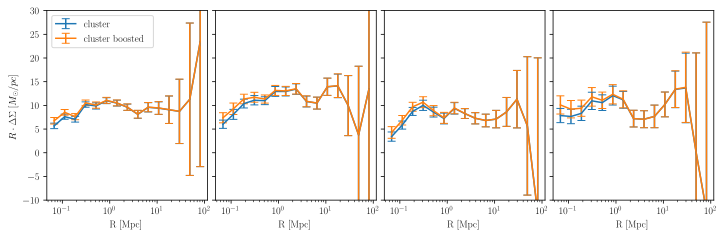

In [16]:
fig, axarr = plt.subplots(ncols=4, figsize=(12, 3.5), sharex=True, sharey=True)
fig.subplots_adjust(wspace=0.05)

for i in np.arange(4):
#     prof = ACP_optms[i]
#     axarr[i].errorbar(prof.rr,  prof.rr * prof.dst, yerr=prof.rr* prof.dst_err, capsize=4, color="C1", ls="-",
#                       label="ismeta=True")
    
    prof = ACP_optms_backup2[i]
    axarr[i].errorbar(prof.rr,  prof.rr * prof.dst, yerr=prof.rr* prof.dst_err, capsize=4, color="C0", ls="-",
                      label="cluster")    
    
    prof = ACPs_PZboosted[i]
    axarr[i].errorbar(prof.rr,  prof.rr * prof.dst, yerr=prof.rr* prof.dst_err, capsize=4, color="C1", ls="-",
                      label="cluster boosted")        
    
    axarr[i].set_xlabel("R [Mpc]")
    axarr[i].set_xscale("log")
#     axarr[i].set_yscale("log")

    axarr[i].set_ylim(-10, 30)
    
axarr[0].legend()
    
    
axarr[0].set_ylabel("$R\cdot\Delta\Sigma$ [$M_\odot  / pc$]")

In [18]:
ACP_optm_rands2 = []
for i, rname in enumerate(rlist):
#     mfac_opt2=1/(1+ms_opt2[i])
    mfac_opt=1/(1+ms_opt[i])

    # processing randoms
    ACP = shearops.AutoCalibrateProfile([rname,], rlist_jk[i], src, xlims=(0.01, 100), sbins=optsbins[i])
    ACP.get_profiles(scinvs=ACP_optms[i].scinvs, weights=weights_rand, ismeta=False, Rs_sbins=Rsel,
                     id_key="ID", z_key="Z", mfactor_sbins=mfac_opt) #
    ACP_optm_rands2.append(ACP)

loading source bin 1
loading source bin 2
loading source bin 3
loading source bin 2
loading source bin 3
loading source bin 2
loading source bin 3
loading source bin 3


In [19]:
# This should reproduce the PZ boost wrapper
class CorrBoost(object):
    def __init__(self, corrs):
        self.boost_amps = [corrs,]

ACPs_boosted_corr = []
for i in np.arange(4): # loop over each lens bin

    profs = ACP_optms[i]._profiles # profile around LRG
    profs_ref = ACP_optm_rands2[i]._profiles # profile around randoms
    
    corrs = []
    for j in np.arange(len(profs)): # loop over each source bin
        
        corr = profs[j].snum / profs_ref[j].snum - 1
        corr = corr / (1 + corr)        
        corrs.append(corr)
        
    cb = CorrBoost(corrs)

    ACP = copy.copy(ACP_optms_backup[i])
    ACP.add_boost(cb)
    
    ACPs_boosted_corr.append(ACP)
        
        

(15,)
0
(15,)
0
(15,)
0
(15,)
0


In [24]:
ACP_optms_backup[0].dst

array([84.3177569 , 68.03961102, 37.96669569, 32.90575132, 19.21765083,
       12.87522983,  7.38837468,  4.07697108,  2.07254836,  1.4780227 ,
        0.87512137,  0.50849693,  0.29508776,  0.23089634,  0.28941709])

In [25]:
ACPs_boosted_corr[0].dst

array([109.43708651,  79.30828161,  41.45959875,  34.67586087,
        20.00575811,  13.22040684,   7.53078968,   4.14158563,
         2.10553345,   1.49715923,   0.88386522,   0.51164901,
         0.29684337,   0.23230549,   0.28800988])

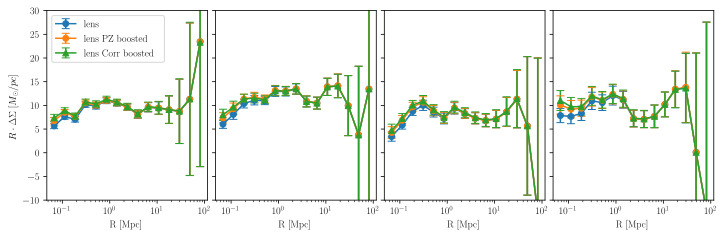

In [32]:
fig, axarr = plt.subplots(ncols=4, figsize=(12, 3.5), sharex=True, sharey=True)
fig.subplots_adjust(wspace=0.05)

for i in np.arange(4):
#     prof = ACP_optms[i]
#     axarr[i].errorbar(prof.rr,  prof.rr * prof.dst, yerr=prof.rr* prof.dst_err, capsize=4, color="C1", ls="-",
#                       label="ismeta=True")
    
    prof = ACP_optms_backup2[i]
    axarr[i].errorbar(prof.rr,  prof.rr * prof.dst, yerr=prof.rr* prof.dst_err, capsize=4, color="C0", ls="-",
                      label="lens", marker="o")    
    
    prof = ACPs_PZboosted[i]
    axarr[i].errorbar(prof.rr,  prof.rr * prof.dst, yerr=prof.rr* prof.dst_err, capsize=4, color="C1", ls="-",
                      label="lens PZ boosted", marker="o", mfc=None)     
    
    prof = ACPs_boosted_corr[i]
    axarr[i].errorbar(prof.rr,  prof.rr * prof.dst, yerr=prof.rr* prof.dst_err, capsize=4, color="C2", ls="-",
                      label="lens Corr boosted", marker="^")        
    
    
    axarr[i].set_xlabel("R [Mpc]")
    axarr[i].set_xscale("log")
#     axarr[i].set_yscale("log")

    axarr[i].set_ylim(-10, 30)
    
axarr[0].legend()
    
    
axarr[0].set_ylabel("$R\cdot\Delta\Sigma$ [$M_\odot  / pc$]")
fig.savefig("boost_comparison_PZ-v-corr_v1.png", dpi=300, bbox_inches="tight")

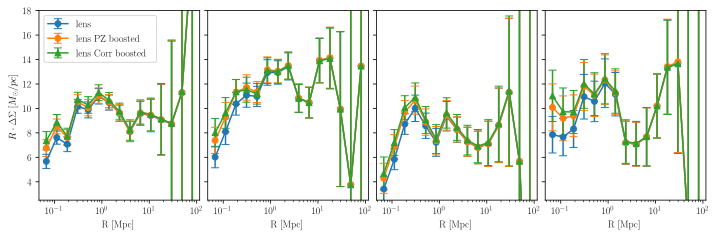

In [31]:
fig, axarr = plt.subplots(ncols=4, figsize=(12, 3.5), sharex=True, sharey=True)
fig.subplots_adjust(wspace=0.05)

for i in np.arange(4):
#     prof = ACP_optms[i]
#     axarr[i].errorbar(prof.rr,  prof.rr * prof.dst, yerr=prof.rr* prof.dst_err, capsize=4, color="C1", ls="-",
#                       label="ismeta=True")
    
    prof = ACP_optms_backup2[i]
    axarr[i].errorbar(prof.rr,  prof.rr * prof.dst, yerr=prof.rr* prof.dst_err, capsize=4, color="C0", ls="-",
                      label="lens", marker="o")    
    
    prof = ACPs_PZboosted[i]
    axarr[i].errorbar(prof.rr,  prof.rr * prof.dst, yerr=prof.rr* prof.dst_err, capsize=4, color="C1", ls="-",
                      label="lens PZ boosted", marker="o", mfc=None)     
    
    prof = ACPs_boosted_corr[i]
    axarr[i].errorbar(prof.rr,  prof.rr * prof.dst, yerr=prof.rr* prof.dst_err, capsize=4, color="C2", ls="-",
                      label="lens Corr boosted", marker="^")        
    
    
    axarr[i].set_xlabel("R [Mpc]")
    axarr[i].set_xscale("log")
#     axarr[i].set_yscale("log")

    axarr[i].set_ylim(2.5, 18)
    
axarr[0].legend()
    
    
axarr[0].set_ylabel("$R\cdot\Delta\Sigma$ [$M_\odot  / pc$]")
fig.savefig("boost_comparison_PZ-v-corr_v1_zoom.png", dpi=300, bbox_inches="tight")

In [36]:
def write_profile(prof, path):
    """saves DeltaSigma and covariance in text format"""

    # Saving profile
    profheader = "R [Mpc]\tDeltaSigma_t [M_sun / pc^2]\tDeltaSigma_t_err [M_sun / pc^2]\tDeltaSigma_x [M_sun / pc^2]\tDeltaSigma_x_err [M_sun / pc^2]"
    res = np.vstack((prof.rr, prof.dst, prof.dst_err, prof.dsx, prof.dsx_err)).T
    fname = path + "_profile.dat"
    print("saving:", fname)
    np.savetxt(fname, res, header=profheader)

    # Saving covariance
    np.savetxt(path + "_dst_cov.dat", prof.dst_cov)
    np.savetxt(path + "_dsx_cov.dat", prof.dsx_cov)

In [37]:
# calculate stack-wise subtraction
profiles_subtracted_PZ = []
for i in np.arange(4):
    prof1 = copy.copy(ACPs_PZboosted[i].profile)
#     prof1 = copy.copy(ACP_optms[i].profile)
    prof2 = copy.copy(ACP_optm_rands2[i].profile)
#     prof = prof1.profile.composite
    prof1.composite(prof2, operation="-")
    profiles_subtracted_PZ.append(prof1)

In [38]:
# tmp_profs = copy.deepcopy(profiles)
fnames = []
for i in np.arange(4):
#     for s in np.arange(3):
#         scinv = scinvs[i][s+1]
#         prof = tmp_profs[i][s]
#         prof.multiply(1 / scinv)
        fname = "LWB_lowz+cmass-100Mpc_boost_rand-subtr_zbin"+str(i)+"_combined_v6_PZ"
        fnames.append(fname)
        prof = profiles_subtracted_PZ[i]
        write_profile(prof, fname)

saving: LWB_lowz+cmass-100Mpc_boost_rand-subtr_zbin0_combined_v6_PZ_profile.dat
saving: LWB_lowz+cmass-100Mpc_boost_rand-subtr_zbin1_combined_v6_PZ_profile.dat
saving: LWB_lowz+cmass-100Mpc_boost_rand-subtr_zbin2_combined_v6_PZ_profile.dat
saving: LWB_lowz+cmass-100Mpc_boost_rand-subtr_zbin3_combined_v6_PZ_profile.dat


In [34]:
# calculate stack-wise subtraction
profiles_subtracted_Corr = []
for i in np.arange(4):
    prof1 = copy.copy(ACPs_boosted_corr[i].profile)
#     prof1 = copy.copy(ACP_optms[i].profile)
    prof2 = copy.copy(ACP_optm_rands2[i].profile)
#     prof = prof1.profile.composite
    prof1.composite(prof2, operation="-")
    profiles_subtracted_Corr.append(prof1)

In [39]:
# tmp_profs = copy.deepcopy(profiles)
fnames = []
for i in np.arange(4):
#     for s in np.arange(3):
#         scinv = scinvs[i][s+1]
#         prof = tmp_profs[i][s]
#         prof.multiply(1 / scinv)
        fname = "LWB_lowz+cmass-100Mpc_boost_rand-subtr_zbin"+str(i)+"_combined_v6_Corr"
        fnames.append(fname)
        prof = profiles_subtracted_Corr[i]
        write_profile(prof, fname)

saving: LWB_lowz+cmass-100Mpc_boost_rand-subtr_zbin0_combined_v6_Corr_profile.dat
saving: LWB_lowz+cmass-100Mpc_boost_rand-subtr_zbin1_combined_v6_Corr_profile.dat
saving: LWB_lowz+cmass-100Mpc_boost_rand-subtr_zbin2_combined_v6_Corr_profile.dat
saving: LWB_lowz+cmass-100Mpc_boost_rand-subtr_zbin3_combined_v6_Corr_profile.dat
